In [1]:
from PuzzleSolver import PuzzleSolver
import cv2
import numpy as np

In [3]:
ps = PuzzleSolver()
pink = np.zeros((1000,1000,3), np.uint8)
pink[:] = (232,8,248)

In [4]:
images = ['img/marian_0.jpg', 'img/marian_1.jpg']

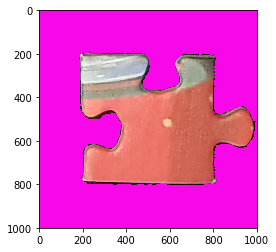

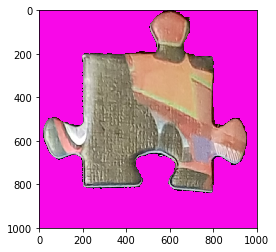

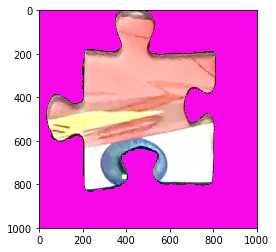

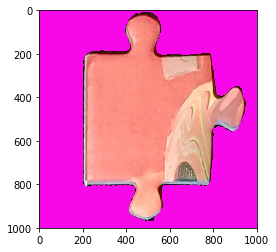

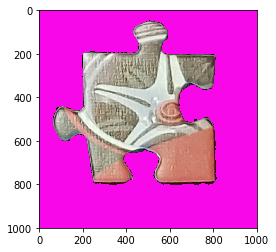

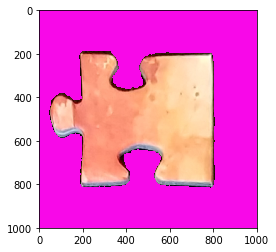

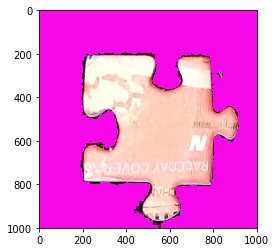

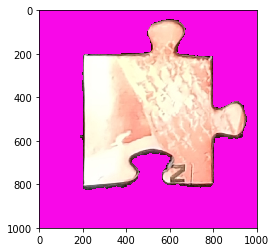

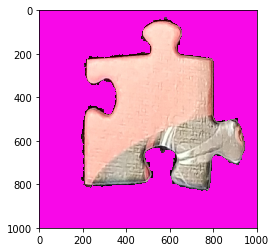

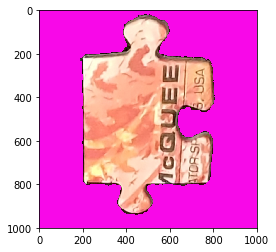

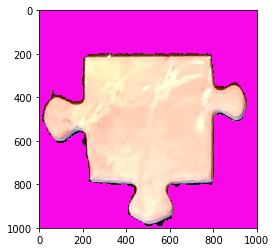

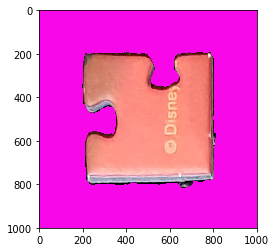

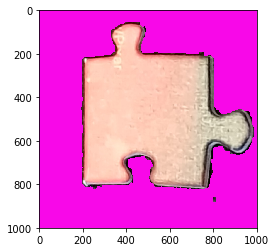

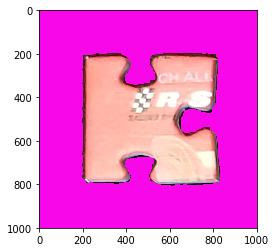

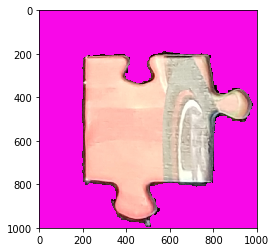

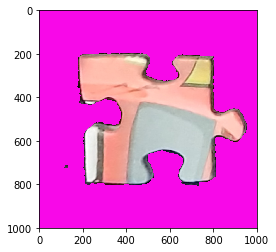

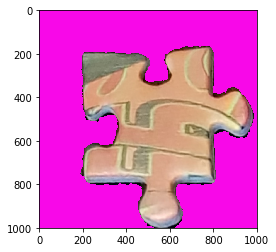

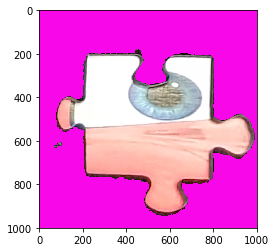

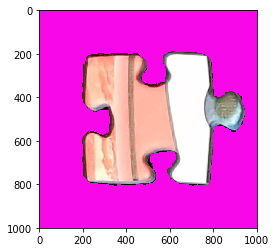

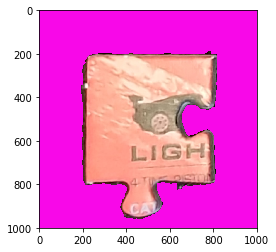

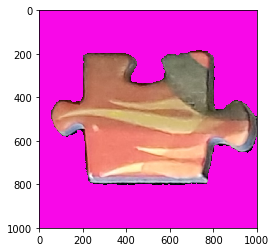

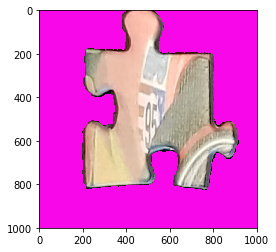

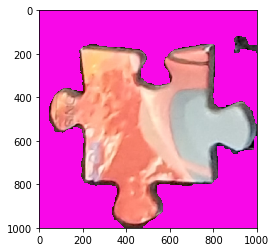

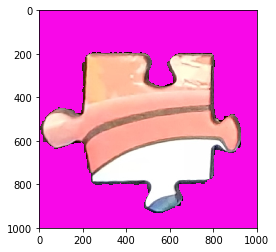

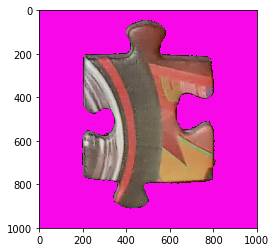

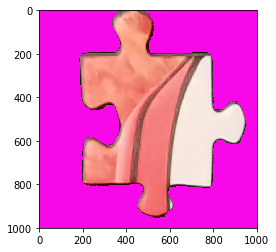

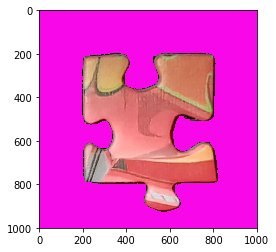

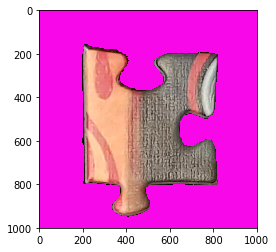

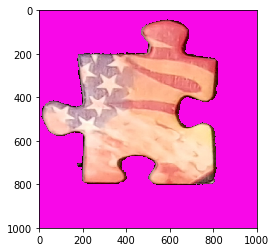

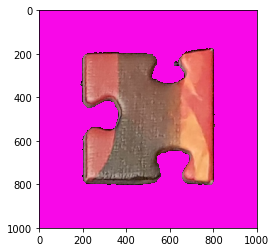

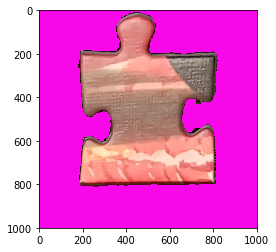

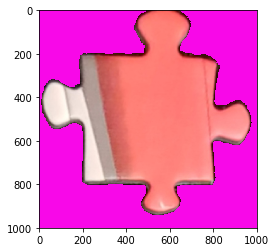

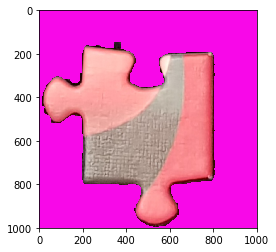

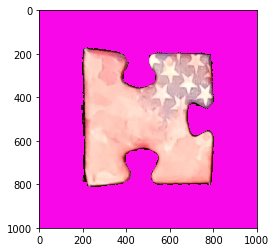

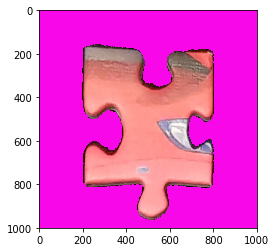

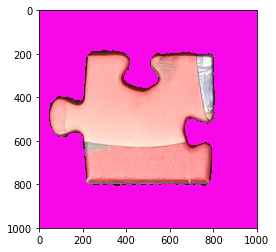

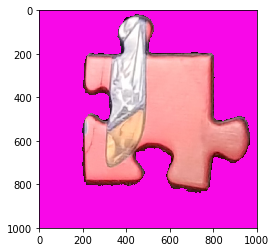

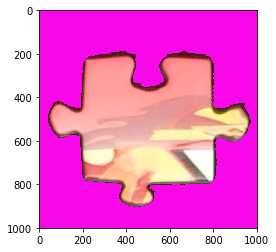

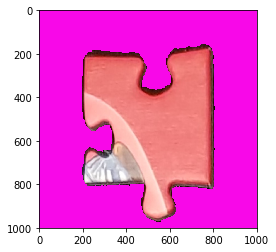

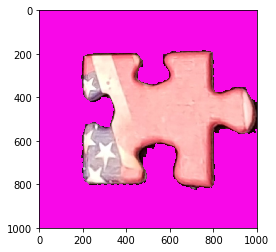

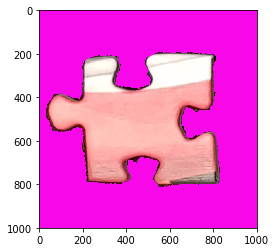

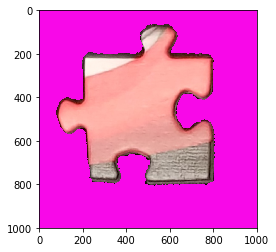

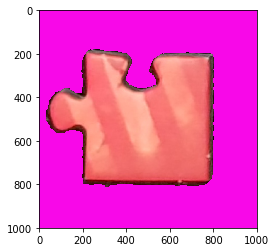

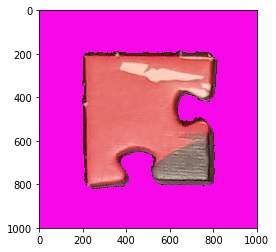

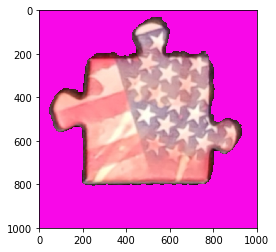

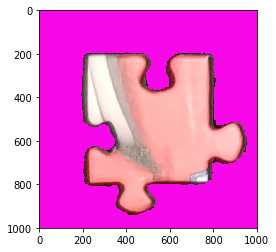

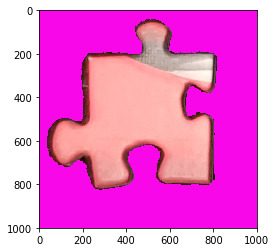

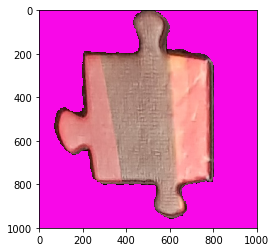

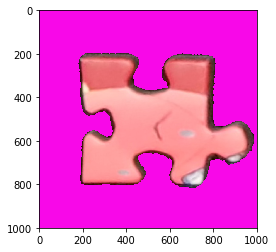

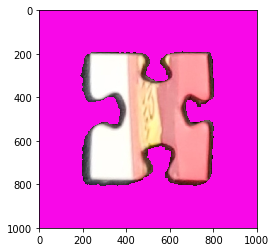

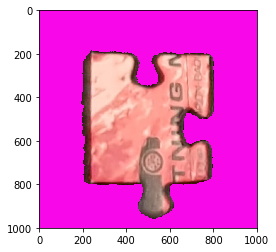

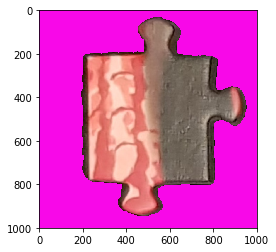

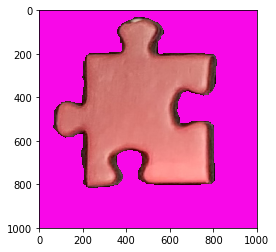

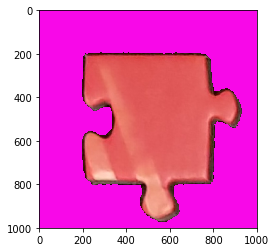

In [5]:
for file in images:
    img = cv2.imread(file)
    splited = ps.split_puzzles_from_image(img)
    for i, im in enumerate(splited):
        a, b = ps.get_transform_image(im)
        b = b.astype('bool')
        a[~b] = pink[~b]
        ps.draw(a)